# Detecting water with radar <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[sentinel1_ghana_monthly]()


## Background

Over 40% of the world’s population lives within 100 km of the coastline.
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats.
Up-to-date data on the position of the coastline is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

While coastlines can be mapped using optical data (demonstrated in the [Coastal Erosion notebook](Coastal_erosion.ipynb)), these images can be strongly affected by the weather, especially through the presence of clouds, which obscure the land and water below.
This can be a particular problem in cloudy regions or areas where wet season clouds prevent optical satellites from taking clear images for many months of the year.

### Sentinel-1 use case

Radar observations are largely unaffected by cloud cover, so can take reliable measurements of areas in any weather.
Radar data is readily available from the ESA/EC Copernicus program's Sentinel-1 satellites.
The two satellites provide all-weather observations, with a revisit time of 6 days.
By developing a process to classify the observed pixels as either water or land, it is possible to identify the shoreline from radar data.
For more information, see the [Sentinel-1 notebook](../Datasets/Sentinel_1.ipynb).

## Description

In this example, we use data from the Sentinel-1 satellites to build a classifier that can determine whether a pixel is water or land in radar data.
Specifically, this notebook uses an analysis-ready radar product known as backscatter, which describes the strength of the signal recieved by the satellite.
The worked example takes users through the code required to:

1. Load Sentinel-1 backscatter data for an area of interest
2. Visualise the returned data.
3. Perform pre-processing steps on the Sentinel-1 bands.
4. Design a classifier to distinguish land and water.
5. Apply the classifier to the area of interest and interpret the results.
6. Investigate how to identify coastal change or the effect of tides.

***

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

sys.path.append("../Scripts")
from deafrica_plotting import display_map

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Radar_water_detection")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `lat`: The central latitude to analyse (e.g. `5.423`).
* `lon`: The central longitude to analyse (e.g. `-0.464`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2017-01', '2017-12') `)

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the coast of Gomoa Fetteh, Ghana.

**To run the notebook for a different area**, make sure Sentinel-1 data is available for the chosen area using the [DE Africa Sandbox Explorer](https://explorer.digitalearth.africa).


In [3]:
# Define the area of interest
lat = 5.423
lon = -0.464
buffer = 0.05

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

# Set the range of dates for the analysis
time = ('2017-01', '2017-12')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
Since there is no time range provided, all available data will be selected.

**Please be patient**.
The data may take a few minutes to load.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [5]:
query = {
    'x': lon_range,
    'y': lat_range,
    'time':time,
}

# Load the data
ds_s1 = dc.load(**query, product="sentinel1_ghana_monthly")

**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `latitude` and `longitude` dimensions.

In [6]:
print(ds_s1)

<xarray.Dataset>
Dimensions:      (latitude: 555, longitude: 554, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-15 2017-02-15 ... 2017-12-15
  * latitude     (latitude) float64 5.473 5.473 5.473 ... 5.373 5.373 5.373
  * longitude    (longitude) float64 -0.5139 -0.5137 -0.5135 ... -0.4142 -0.414
    spatial_ref  int32 4326
Data variables:
    vh           (time, latitude, longitude) float32 -15.172445 ... -26.189959
    vv           (time, latitude, longitude) float32 -10.06167 ... -20.011625
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


### Visualise loaded data

Sentinel-1 backscatter data has two measurements, *VV* and *VH*, which correspond to the polarisation of the light sent and received by the satellite.
*VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back.
These two measurement bands can tell us different information about the area we're studying. 


#### Visualise VH band

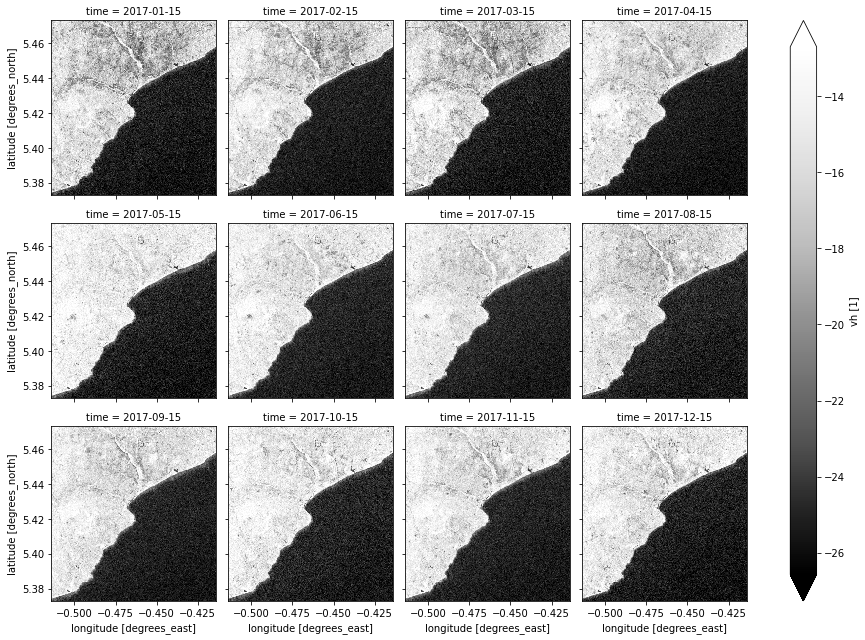

In [7]:
# Plot all VH observations for the year
ds_s1.vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=4)
plt.show()

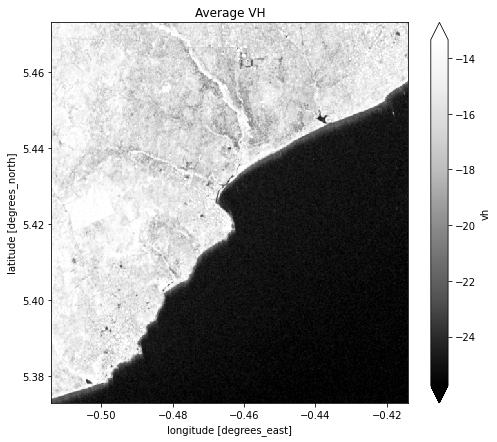

In [8]:
# Plot the average of all VH observations
mean_vh = ds_s1.vh.mean(dim="time")

fig = plt.figure(figsize=(8, 7))
mean_vh.plot(cmap="Greys_r", robust=True)
plt.title("Average VH")
plt.show()

What key differences do you notice between each individual observation and the mean?

#### Visualise VV band

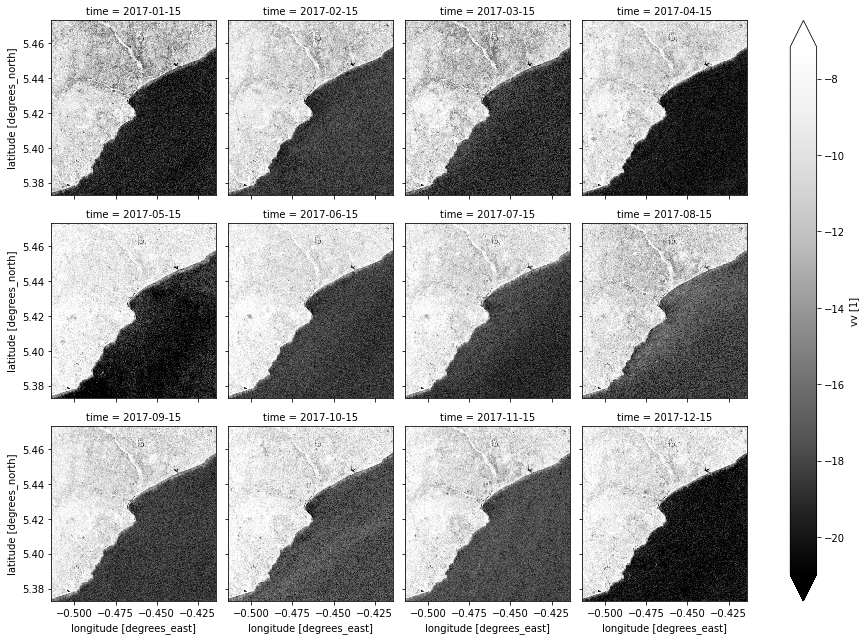

In [9]:
# Plot all VV observations for the year
ds_s1.vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=4)
plt.show()

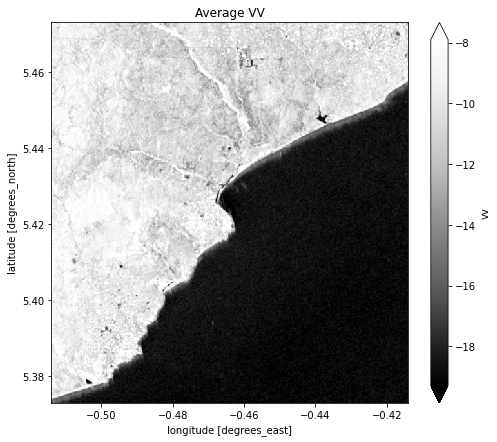

In [10]:
# Plot the average of all VV observations
mean_vv = ds_s1.vv.mean(dim="time")

fig = plt.figure(figsize=(8, 7))
mean_vv.plot(cmap="Greys_r", robust=True)
plt.title("Average VV")
plt.show()

What key differences do you notice between each individual observation and the mean? What about differences between the average *VH* and *VV* bands?

Take a look back at the map image to remind yourself of the shape of the land and water of our study area. In both bands, what distinguishes the land and the water?

## Preprocessing the data through filtering

### Speckle Filtering using Lee Filter

You may have noticed that the water in the individual *VV* and *VH* images isn't a consistent colour.
The distortion you're seeing is a type of noise known as speckle, which gives the images a grainy appearence.
If we want to be able to easily decide whether any particular pixel is water or land, we need to reduce the chance of misinterpreting a water pixel as a land pixel due to the noise.

Speckle can be removed through filtering.
If interested, you can find a technical introduction to speckle filtering [here](https://earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf).
For now, it is enough to know that we can filter the data using the Python function defined in the next cell:

In [11]:
# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Now that we've defined the filter, we can run it on the *VV* and *VH* data.
You might have noticed that the function takes a `size` argument.
This will change how blurred the image becomes after smoothing.
We've picked a default value for this analysis, but you can experiement with this if you're interested.

In [12]:
# Set any null values to 0 before applying the filter to prevent issues
ds_s1_filled = ds_s1.where(~ds_s1.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds_s1["filtered_vv"] = ds_s1_filled.vv.groupby("time").apply(lee_filter, size=7)
ds_s1["filtered_vh"] = ds_s1_filled.vh.groupby("time").apply(lee_filter, size=7)


### Visualise filtered data

We can now visualise the filtered bands in the same way as the original bands.
Note that the filtered values must also be converted to decibels before being displayed.

#### Visualise filtered VH band

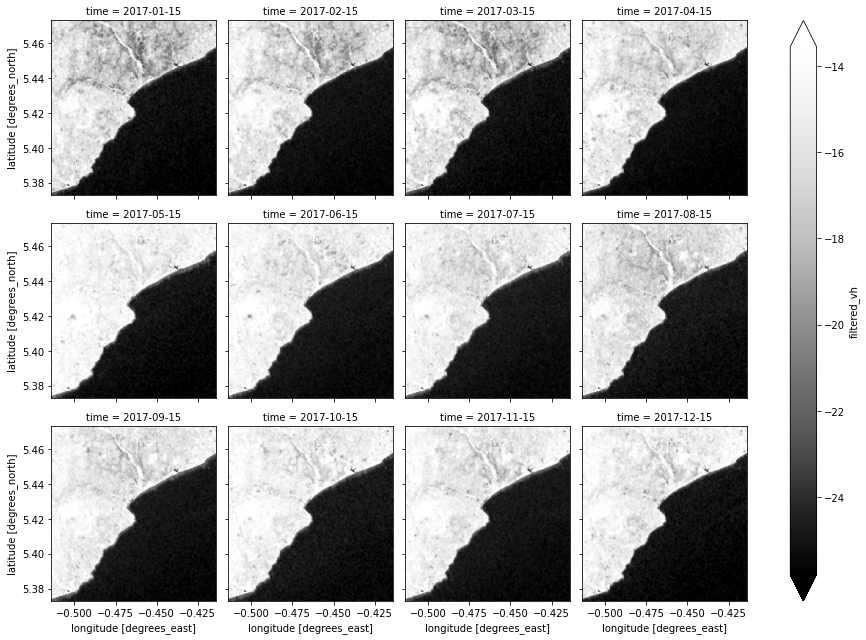

In [13]:
# Plot all filtered VH observations for the year
ds_s1.filtered_vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=4)
plt.show()

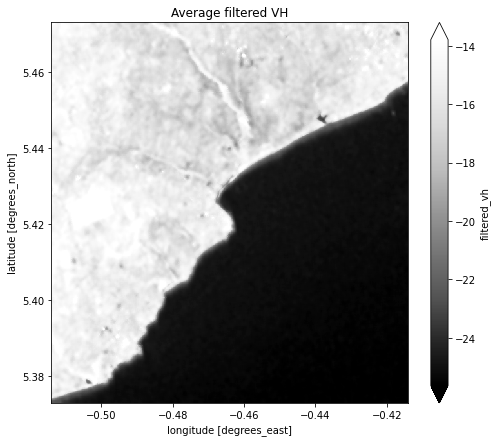

In [14]:
# Plot the average of all filtered VH observations
mean_filtered_vh = ds_s1.filtered_vh.mean(dim="time")

fig = plt.figure(figsize=(8, 7))
mean_filtered_vh.plot(cmap="Greys_r", robust=True)
plt.title("Average filtered VH")
plt.show()

#### Visualise filtered VV band

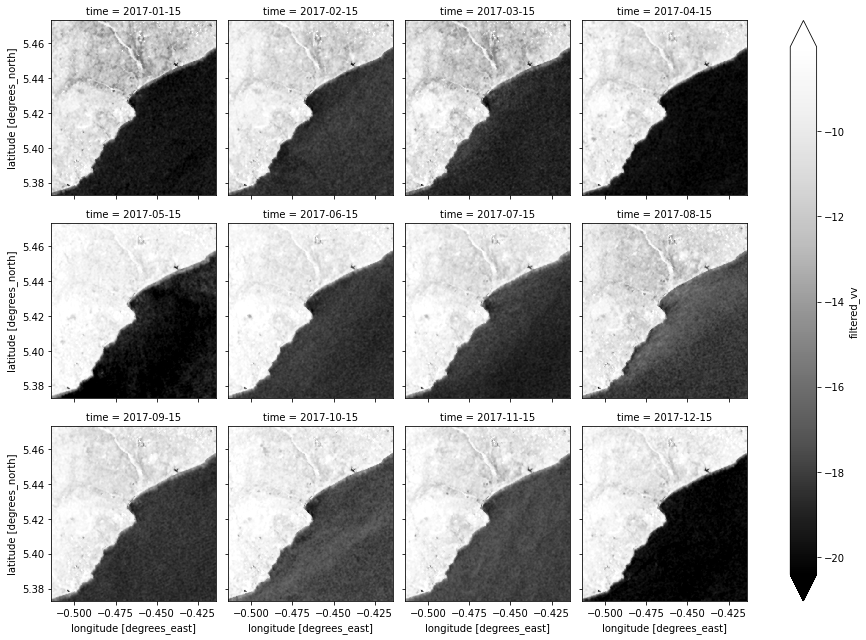

In [15]:
# Plot all filtered VV observations for the year
ds_s1.filtered_vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=4)
plt.show()

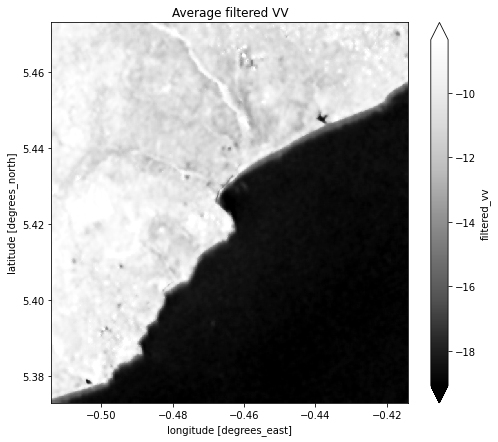

In [16]:
# Plot the average of all filtered VV observations
mean_filtered_vv = ds_s1.filtered_vv.mean(dim="time")

fig = plt.figure(figsize=(8, 7))
mean_filtered_vv.plot(cmap="Greys_r", robust=True)
plt.title("Average filtered VV")
plt.show()

Now that you've finished filtering the data, compare the plots before and after and you should be able to notice the impact of the filtering.
If you're having trouble spotting it, it's more noticable in the VH band. 

### Plotting VH and VV histograms

Another way to observe the impact of filtering is to view histograms of the pixel values before and after filtering.
Try running the next two cells to view the histograms for *VH* and *VV*.

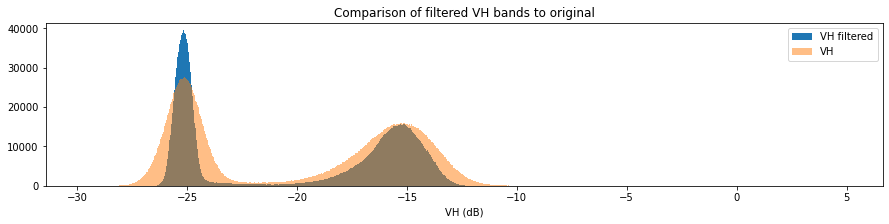

In [17]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
ds_s1.vh.plot.hist(bins=1000, label="VH", alpha=0.5)
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Comparison of filtered VH bands to original")
plt.show()

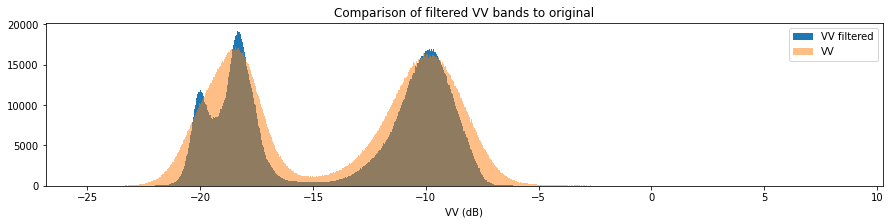

In [18]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vv.plot.hist(bins=1000, label="VV filtered")
ds_s1.vv.plot.hist(bins=1000, label="VV", alpha=0.5)
plt.legend()
plt.xlabel("VV (dB)")
plt.title("Comparison of filtered VV bands to original")
plt.show()

You may have noticed that both the original and filtered bands show two peaks in the histogram, which we can classify as a bimodal distribution.
Looking back at the band images, it's clear that the water pixels generally have lower *VH* and *VV* values than the land pixels.
This lets us conclude that the lower distribution corresponds to water pixels and the higher distribution corresponds to land pixels.
Importantly, the act of filtering has made it clear that the two distributions can be separated, which is especially obvious in the *VH* histogram.
This allows us to confidently say that pixel values below a certain threshold are water, and pixel values above it are land.
This will form the basis for our classifier in the next section.

## Designing a threshold-based water classifier

Given that the distinction between the `land` and `water` pixel value distributions is strongest in the *VH* band, we'll base our classifier on this distribution.
To separate them, we can choose a threshold: pixels with values below the threshold are water, and pixels with values above the threshold are not water (land).

There are a number of ways to determine the threshold; one is to estimate it by looking at the *VH* histogram.
From this, we might guess that $\text{threshold} = -22.0$ is a reasonable value.
Run the cell below to set the threshold.

In [19]:
threshold = -22.0

The classifier separates data into two classes: data above the threshold and data below the threshold.
In doing this, we assume that values of both segments correspond to the same `water` and `not water` distinctions we make visually.
This can be represented with a step function:

$$  \text{water}(VH) = \left\{
     \begin{array}{lr}
       \text{True} & :   VH < \text{threshold}\\
       \text{False} & :  VH \geq \text{threshold}
     \end{array}
   \right.\\ $$  

<br>


### Visualise threshold

To check if our chosen threshold reasonably divides the two distributions, we can add the threshold to the histogram plots we made earlier.
Run the next two cells to view two different visualisations of this.

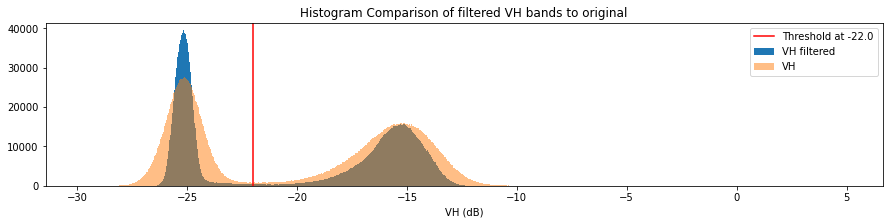

In [20]:
fig = plt.figure(figsize=(15, 3))
plt.axvline(x=threshold, label=f"Threshold at {threshold}", color="red")
ds_s1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
ds_s1.vh.plot.hist(bins=1000, label="VH", alpha=0.5)
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Histogram Comparison of filtered VH bands to original")
plt.show()

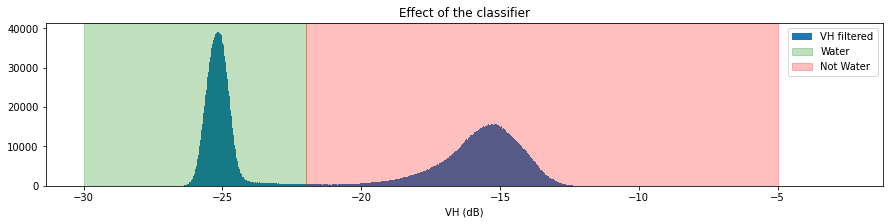

In [21]:
fig, ax = plt.subplots(figsize=(15, 3))
ds_s1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
ax.axvspan(xmin=-30.0, xmax=threshold, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold,
           xmax=-5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

If you're curious about how changing the threshold impacts the classifier, try changing the threshold value and running the previous two cells again.

## Build and apply the classifier

Now that we know the threshold, we can write a function to only return the pixels that are classified as water. The basic steps that the function will perform are:

1. Clean the data by applying the speckle filter.
2. Find all pixels that have filtered values lower than the threshold; these are the `water` pixels.
3. Return a data set containing the `water` pixels.

These steps correspond to the actions taken in the function below.
See if you can determine which parts of the function map to each step before you continue.

In [22]:
def s1_water_classifier(ds, threshold=-22.0):
    filtered = ds.vh.groupby("time").apply(lee_filter, size=7)
    water_data_array = filtered < threshold
    return water_data_array.to_dataset(name="s1_water")

Now that we have defined the classifier function, we can apply it to the data.
After you run the classifier, you'll be able to view the classified data product by running `print(ds_s1.water)`.

In [23]:
ds_s1["water"] = s1_water_classifier(ds_s1).s1_water

In [24]:
print(ds_s1.water)

<xarray.DataArray 'water' (time: 12, latitude: 555, longitude: 554)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...

### Assessment with mean

We can now view the image with our classification.
The classifier returns either `True` or `False` for each pixel.
To detect the shoreline, we want to check which pixels are always water and which are always land.
Conveniently, Python encodes `True = 1` and `False = 0`.
If we plot the average classified pixel value, pixels that are always water will have an average value of `1` and pixels that are always land will have an average of `0`.
Pixels that are sometimes water and sometimes land will have an average between these values.

The following cell plots the average classified pixel value over time.
How might you classify the shoreline from the average classification value?

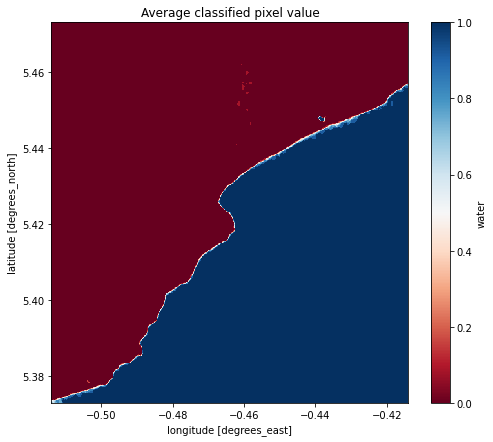

In [25]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(8, 7))
ds_s1.water.mean(dim="time").plot(cmap="RdBu")
plt.title("Average classified pixel value")
plt.show()

#### Interpreting the mean classification 

You can see that our threshold has done a good job of separating the water pixels (in blue) and land pixels (in red). 

You should be able to see that the shoreline takes on a mix of values between `0` and `1`, highlighting pixels that are sometimes land and sometimes water.
This is likely to due the effect of rising and falling tides, with some radar observations being captured at low tide, and others at high tide. 



### Assessment with standard deviation

Given that we've identified the shoreline as the pixels that are classified sometimes as land and sometimes as water, we can also see if the standard deviation of each pixel in time is a reasonable way to determine if a pixel is shoreline or not.
Similar to how we calculated and plotted the mean above, you can calculate and plot the standard deviation by using the `std` function in place of the `mean` function.

If you'd like to see the results using a different colour-scheme, you can also try substituting `cmap="Greys"` or `cmap="Blues"` in place of `cmap="viridis"`.

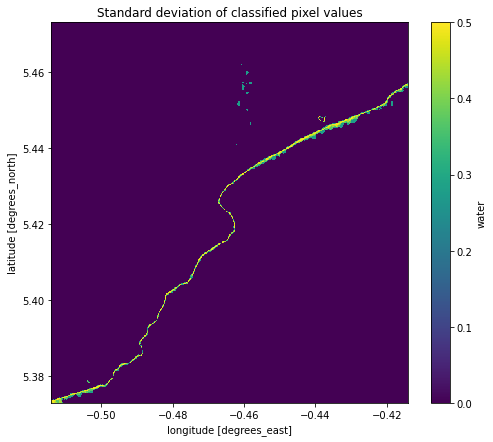

In [26]:
# Plot the standard deviation of each classified pixel value
plt.figure(figsize=(8, 7))
ds_s1.water.std(dim="time").plot(cmap="viridis")
plt.title("Standard deviation of classified pixel values")
plt.show()

#### Interpreting the standard deviation of the classification

From the image above, you should be able to see that the land and water pixels almost always have a standard deviation of `0`, meaning they didn't change over the time we sampled.
Areas along the coastline however have a higher standard deviation, indicating that they change frequently between water and non-water (potentially due to the rise and fall of the tide). 
With further investigation, you could potentially turn this statistic into a new classifier to extract shoreline pixels.
If you're after a challenge, have a think about how you might approach this.

An important thing to recognise is that the standard deviation might not be able to detect the difference between noise, tides and ongoing change, since a pixel that frequently alternates between land and water (noise) could have the same standard deviation as a pixel that is land for some time, then becomes water for the remaining time (ongoing change or tides).
Consider how you might distinguish between these different cases with the data and tools you have.

## Detecting change between two images

The standard deviation we calculated before gives us an idea of how variable a pixel has been over the entire period of time that we looked at.
It might also be interesting to look at which pixels have changed between any two particular times in our sample.

In the next cell, we choose the images to compare.
Printing the dataset should show you that there are 12 time-steps, so the first has an index value of `0`, and the last has an index value of `11`.
You can change these to be any numbers in between, as long as the start is earlier than the end.

In [27]:
start_time_index = 0
end_time_index = 11

Next, we can define the change as the difference in the classified pixel value at each point.
Land becoming water will have a value of `-1` and water becoming land will have a value of `1`.

In [28]:
change = np.subtract(ds_s1.water.isel(time=start_time_index),
                     ds_s1.water.isel(time=end_time_index),
                     dtype=np.float32)

# Set all '0' entries to NaN, which prevents them from displaying in the plot.
change = change.where(change != 0)
ds_s1["change"] = change

Now that we've added change to the dataset, you should be able to plot it below to look at which pixels changed. 
You can also plot the original mean *VH* composite to see how well the change matches our understanding of the shoreline location.


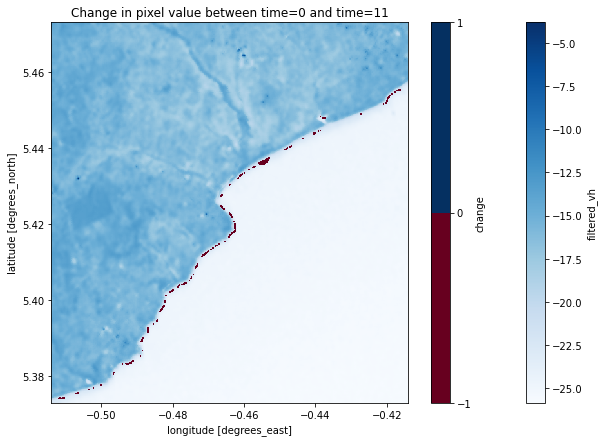

In [29]:
plt.figure(figsize=(10, 7))
ds_s1.filtered_vh.mean(dim="time").plot(cmap="Blues")
ds_s1.change.plot(cmap="RdBu", levels=2)
plt.title(f"Change in pixel value between time={start_time_index} and time={end_time_index}")
plt.show()

### Coastal change or tides?

Tides can greatly affect the appearance of the coastline, particularly where tidal ranges are large.
Without additional data, it is difficult to determine whether the change above is due to the coastline having eroded over time, or because the two radar images were captured at different tides (e.g. low vs. high tide).
The radar water classifier in this notebook could potentially be combined with tidal modelling from the [Coastal Erosion notebook](Coastal_erosion.ipynb) to look into this question in more detail.

## Drawing conclusions
Here are some questions to think about:

* What are the benefits and drawbacks of the possible classification options we explored?
* How could you extend the analysis to extract a shape for the coastline?
* How reliable is our classifier?
* Is there anything you can think of that would improve it?

## Next steps
When you are done, return to the "Analysis parameters" section, modify some values (e.g. `lat` and `lon`) and rerun the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

If you're going to change the location, you'll need to make sure Sentinel-1 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/sentinel1_ghana_monthly).

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** March 2020

**Compatible `datacube` version:** 

In [30]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()